In [1]:
library(hipathia)
library(circlize)
library(ComplexHeatmap)
library(ggplot2)
library(corrplot)
library(hipathia)
library(reshape2)
library(dplyr)
library(ggdendro)
library(limma)
library(factoextra)

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: AnnotationHub

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:igraph’:

    normalize, path, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: BiocFileCache



In [2]:
### get data and annotations

In [3]:
annot_splattrib <- read.table("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/data/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep="\t", header=T)
pathvals_gtex <- readRDS("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/results/00_mm_gtex/pathvals_gtexv8.rds")
annot_splattrib_comp <- annot_splattrib[annot_splattrib$SAMPID %in% colnames(pathvals_gtex),]
annot_splattrib_comp <- annot_splattrib_comp[annot_splattrib_comp$SMTSD != "",]

pathways <- load_pathways("hsa")
pathvals <- assay(pathvals_gtex)
path_names <- get_path_names(pathways,rownames(pathvals))
rownames(pathvals) <- path_names

annot_subph <- read.table("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/data/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt", sep="\t", header=T)
rownames(annot_subph) <- annot_subph$SUBJID

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”
Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“number of items read is not a multiple of the number of columns”
Loaded 146 pathways



In [4]:
annot_splattrib_sl <- annot_splattrib[,c("SAMPID","SMTS","SMTSD")]
rownames(annot_splattrib_sl) <- annot_splattrib_sl$SAMPID

comp_pat <- intersect(annot_splattrib_sl$SAMPID, colnames(pathvals))
subjib_comp_pat <- paste("GTEX-",unique(unlist(lapply(strsplit(comp_pat,"-", fixed=T), FUN=function(x) x[2]))), sep="")

annot_subph_comp <- annot_subph[subjib_comp_pat,]                                                                 
list_patient <- lapply(annot_subph_comp$SUBJID, FUN=function(x) annot_splattrib_sl$SAMPID[grep(x, annot_splattrib_sl$SAMPID)])
list_sex <- do.call(list,lapply(1:length(annot_subph_comp$SEX), function(x) rep(annot_subph_comp$SEX[x],length(unlist(list_patient[x])))))                       
list_age <- do.call(list,lapply(1:length(annot_subph_comp$AGE), function(x) rep(annot_subph_comp$AGE[x],length(unlist(list_patient[x])))))   
pat_sex_age <- data.frame(patients = unlist(list_patient),
                                   sex = unlist(list_sex),
                                   age = unlist(list_age))
rownames(pat_sex_age) <- pat_sex_age$patients

pat_sex_age_comp <- pat_sex_age[comp_pat,]
pat_sex_age_comp$sex[which(pat_sex_age_comp$sex == 2)] <- "female"
pat_sex_age_comp$sex[which(pat_sex_age_comp$sex == 1)] <- "male"
pat_sex_age_comp$tissue <- annot_splattrib_sl[pat_sex_age_comp$patients,"SMTS"]                                
pat_sex_age_comp$tissue_zone <- annot_splattrib_sl[pat_sex_age_comp$patients,"SMTSD"] 
annot_comp <- pat_sex_age_comp[,c("patients","age","sex","tissue","tissue_zone")]    
annot_comp <- annot_comp[annot_comp$tissue_zone != "",]

In [5]:
annot_comp_fcells <- annot_comp[-c(which(annot_comp$tissue_zone == 'Cells - Cultured fibroblasts'), which(annot_comp$tissue_zone == 'Cells - EBV-transformed lymphocytes')),]
pathvals_fcells <- pathvals[,annot_comp[-c(which(annot_comp$tissue_zone == 'Cells - Cultured fibroblasts'), which(annot_comp$tissue_zone == 'Cells - EBV-transformed lymphocytes')),"patients"]]

physiological_paths <- read.table("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/data/physiological_paths.tsv", sep="\t") 
pathvals_fcells_phys <- pathvals_fcells[unlist(lapply(physiological_paths$V1, FUN=function(x) grep(x,rownames(pathvals_fcells)))),]

In [6]:
tissues_common <- data.frame(annot_comp_fcells %>% group_by(sex, tissue) %>% summarise(n=n()) %>% filter(n>2) %>%
group_by(tissue) %>% summarise(n=n()) %>% filter(n==2))$tissue

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


In [7]:
### clustering

In [8]:
annot_comp_fcells_female <- annot_comp_fcells %>% filter(sex == "female")
#tissues_female <- unique(annot_comp_fcells_female$tissue)

pathvals_mean_female <- as.data.frame(lapply(tissues_common, function(x) apply(pathvals_fcells_phys[,annot_comp_fcells_female[which(annot_comp_fcells_female$tissue == x),"patients"]], 1, mean)))
colnames(pathvals_mean_female) <- tissues_common
rownames(pathvals_mean_female) <- rownames(pathvals_fcells_phys)      

jpeg("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/results/04_comparation_sex_in_tissues/cluster_comparation_sex_female_tissues.jpeg", quality = 100, width = 600, height = 400)                                                                                                                                     
dist_female <- dist(t(pathvals_mean_female),method="euclidean")
hc1_female <- hclust(dist_female, method = "complete" )
fviz_dend(hc1_female, cex = 0.8, k=7, 
          rect = TRUE,  
          k_colors = "aaas",
          rect_border = "aaas", 
          rect_fill = TRUE, 
          horiz = TRUE, main=NULL) 
#plot(hc1_female, col = "#487AA1", col.main = "#45ADA8", col.lab = "#7C8071", cex = 1,
#    col.axis = "#F38630", lwd = 2, lty = 2, sub = "", hang = -1, axes = FALSE, main="")                                                                                          
dev.off()                                             

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the factoextra package.
  Please report the issue at <https://github.com/kassambara/factoextra/issues>.”


png 
  2

In [9]:
annot_comp_fcells_male <- annot_comp_fcells %>% filter(sex == "male")
#tissues_male <- unique(annot_comp_fcells_male$tissue)

pathvals_mean_male <- as.data.frame(lapply(tissues_common, function(x) apply(pathvals_fcells_phys[,annot_comp_fcells_male[which(annot_comp_fcells_male$tissue == x),"patients"]], 1, mean)))
colnames(pathvals_mean_male) <- tissues_common
rownames(pathvals_mean_male) <- rownames(pathvals_fcells_phys)      

jpeg("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/results/04_comparation_sex_in_tissues/cluster_comparation_sex_male_tissues.jpeg", quality = 100, width = 600, height = 400)                                                                                                                                                                                
dist_male <- dist(t(pathvals_mean_male),method="euclidean")
hc1_male <- hclust(dist_male, method = "complete" )
#plot(hc1_male, col = "#487AA1", col.main = "#45ADA8", col.lab = "#7C8071", cex = 1,
#    col.axis = "#F38630", lwd = 2, lty = 2, sub = "", hang = -1, axes = FALSE, main="")                                                                                          
fviz_dend(hc1_male, cex = 0.8, k=5, 
          rect = TRUE,  
          k_colors = "aaas",
          rect_border = "aaas", 
          rect_fill = TRUE, 
          horiz = TRUE, main=NULL)                                            
dev.off()                                           

png 
  2

In [10]:
### limma

In [11]:
limma_funct <- function(x){
    pathvals <- pathvals_fcells_phys[,annot_comp_fcells[x == annot_comp_fcells$tissue,"patients"]]
    type <- annot_comp_fcells[which(x== annot_comp_fcells$tissue),"sex"]
    design <- model.matrix(~type)
    fit <- lmFit(pathvals, design)
    fit2 <- eBayes(fit)
    top_table <- topTable(fit2, number = Inf, p.value = 1, coef = "typemale", adjust="fdr")
    top_table$tissue <- rep(x, length(rownames(top_table)))
    top_table$circ <- rownames(top_table)
    return(top_table)
}

limma_sex_tissue <- do.call(rbind,lapply(tissues_common, FUN=function(x) limma_funct(x)))
limma_sex_tissue_sign <- limma_sex_tissue[limma_sex_tissue$adj.P.Val < 0.05,]           

Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message:
“Zero sample variances detected, have been offset away from zero”


In [18]:
heatmap_fc <- limma_sex_tissue_sign %>% ggplot(aes(x= tissue, y = circ, fill = logFC)) +
  geom_tile() + scale_fill_gradient2(name="logFC",low="darkred",mid="white",
    high = "darkgreen",
    na.value = "") +
  scale_x_discrete(name="Tissues",expand = expansion(mult = c(0,0)), guide = guide_axis(angle = 90)) + theme(axis.text.y= element_text(size=7),axis.text.x= element_text(size=15)) + 
scale_y_discrete(name="Physiological circuits") + ggtitle("") + theme_minimal()                                                      

In [19]:
jpeg("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/results/04_comparation_sex_in_tissues/heatmap_comparation_sex_tissues.jpeg", quality = 100, width = 500, height = 1000)                                                                                                                                    
print(heatmap_fc)
dev.off()

png 
  2

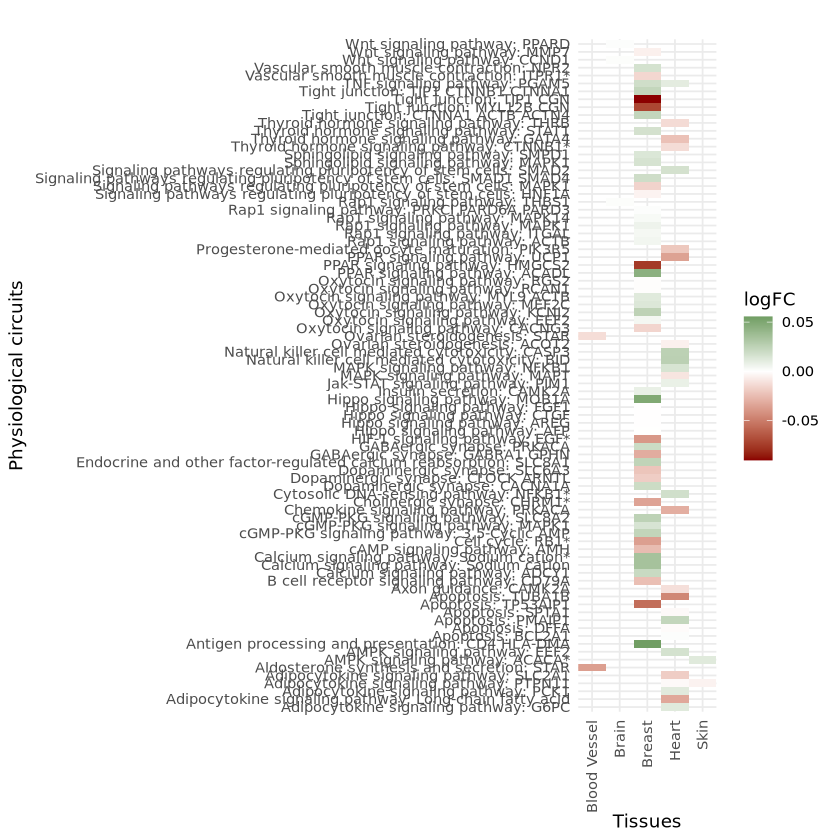

In [20]:
heatmap_fc

In [ ]:
### gene belogns circuits in sexual chromosomes

In [46]:
library(hipathia)
library(AnnotationDbi)
library(org.Hs.eg.db)

## dataframe for each gene belong to pathway.

pathways <- load_pathways("hsa")
names_circs <- names(pathways$pathigraphs)
# extrac genes from a pathways
f_extract_genes <- function(j){

	genes <- unique(na.omit(unlist(V(getElement(get_element, j))$genesList)))
	genes_clean <- genes[genes != "/" & genes != "NA"]
	return(genes_clean)
}

# join every genes of every path
genes_com <- c()
circs_com <- c()
df <- c()

for (i in 1:length(names_circs)){
	x <- names_circs[i]
	get_element <- getElement(pathways$pathigraphs,x)$effector.subgraphs

	list_path_genes <- sapply(names(get_element), f_extract_genes)

	genes <- paste(do.call(c, list_path_genes)) 
	circs <- paste(do.call(c,sapply(1:length(list_path_genes), FUN=function(z) rep(names(list_path_genes)[z], length(list_path_genes[[z]])))))	
	genes_com <- c(genes_com, genes)
	circs_com <- c(circs_com, circs)	
}


circ_genes <- data.frame(circs = circs_com, genes = genes_com)

Loaded 146 pathways



In [47]:
circ_genes$names_circs <- get_path_names(pathways, df_circ_genes$circs)

In [100]:
gene_circs_sign_tiss <- merge(limma_sex_tissue_sign[,c("circ","tissue")], circ_genes, by.x="circ", by.y="names_circs")

In [101]:
x <- org.Hs.egCHR
mapped_genes <- mappedkeys(x)
xx <- as.list(x[mapped_genes])
gen_chrom <- as.data.frame(do.call(rbind, xx))
gen_chrom$gen <- rownames(gen_chrom)

gene_chr_circs_sign_tiss <- merge(gene_circs_sign_tiss, gen_chrom, by.x="genes",by.y="gen")
gene_chr_circs_sign_tiss$genename <- AnnotationDbi::select(org.Hs.eg.db, keys=paste(gene_chr_circs_sign_tiss$genes), columns=c("SYMBOL"),keytype="ENTREZID")$SYMBOL

Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 477)”
'select()' returned many:1 mapping between keys and columns



In [104]:
gene_chr_circs_sign_tiss <- as.data.frame(gene_chr_circs_sign_tiss %>% filter(V1=="X" | V2=="X"| V3=="X" | V1=="Y" | V2=="Y"| V3=="Y") %>% 
mutate(chr = case_when(V1 == "X" & V2 == "X" & V3 == "X" ~ "X",
                       V1 == "X" & V2 == "Y" & V3 == "X" ~ "X,Y",
                       V1 == "Y" & V2 == "Y" & V3 == "Y" ~ "Y",
                       V1 == "Y" & V2 == "X" & V3 == "X" ~ "X,Y",
                       V1 == "X" & V2 == "X" & V3 == "Y" ~ "X,Y",
                       V1 == "X" & V2 == "Y" & V3 == "Y" ~ "X,Y",
                       V1 == "Y" & V2 == "X" & V3 == "Y" ~ "X,Y",
                       V1 == "Y" & V2 == "Y" & V3 == "X" ~ "X,Y")))[,c("genename", "circ", "tissue", "chr")]


In [112]:
unique(gene_chr_circs_sign_tiss$tissue)

[1] "Breast" "Heart"  "Brain"

In [114]:
gene_chr_circs_sign_tiss$paths <- unlist(lapply(strsplit(gene_chr_circs_sign_tiss$circ,":", fixed=T), FUN=function(x) x[1]))
gene_chr_circs_sign_tiss %>% filter(tissue=="Breast") %>% group_by(paths) %>% summarise(n=n())

paths,n
<chr>,<int>
Calcium signaling pathway,2
Dopaminergic synapse,1
Endocrine and other factor-regulated calcium reabsorption,1
GABAergic synapse,3
HIF-1 signaling pathway,2
Hippo signaling pathway,4
Insulin secretion,1
Oxytocin signaling pathway,1
Rap1 signaling pathway,20


In [105]:
write.csv(gene_chr_circs_sign_tiss,file="/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/results/04_comparation_sex_in_tissues/table_genes_belong_circ_dif_comparation_sex_in_tissues.csv", row.names=F)